<a href="https://colab.research.google.com/github/himanshag/Genre-Detection/blob/main/Plant_Diseases_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


First mount google drive on colab to the dataset directly from google drive. 

In [2]:
# files present in "/content/drive/MyDrive/GitProjects/PlantDisease-Streamlit/Data/Plant_images/".
!ls "/content/drive/MyDrive/GitProjects/PlantDisease-Streamlit/Data/Plant_images/"

'Corn_(maize)___Common_rust_'   Potato___Early_blight   Tomato___Bacterial_spot


In [3]:
#Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical 

Importing all the required libraries, For CNN model all the required layers, activations, optimizers, etc. are imported as well.

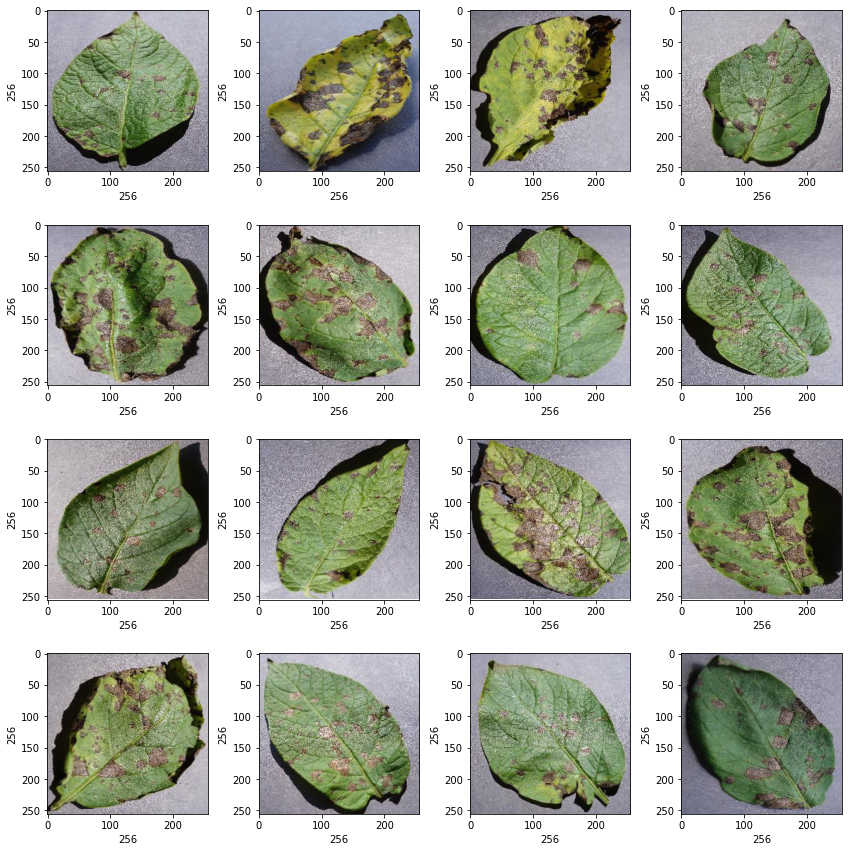

In [4]:
# Plotting 16 images to check dataset
plt.figure(figsize=(12,12))
path = "/content/drive/MyDrive/GitProjects/PlantDisease-Streamlit/Data/Plant_images/Potato___Early_blight"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

In [5]:
#Converting Images to array 
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256,256))  
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

convert the images into a numpy array, it is required to normalize the dataset

In [6]:
dir = "/content/drive/MyDrive/GitProjects/PlantDisease-Streamlit/Data/Plant_images"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Corn-Common_rust', 'Potato-Early_blight', 'Tomato-Bacterial_spot']
binary_labels = [0,1,2]
temp = -1

# Reading and converting image to numpy array
for directory in root_dir:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])

In [7]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

0    300
1    300
2    300
dtype: int64

Observing the number of images under different classes and checking if the dataset is balanced

In [8]:
image_list[0].shape

(256, 256, 3)

In [9]:
label_list = np.array(label_list)
label_list.shape

(900,)

Using sklearn train_test_split to split the dataset into testing and training data.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) 

In [11]:
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 256,256,3)
x_test = x_test.reshape( -1, 256,256,3)

Now normalize the dataset. As pixel values ranges from 0 to 255 so divide each image pixel with 255 to normalize the dataset.

In [12]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Creating a network architecture for the model, using different types of layers according to their features namely Conv_2d (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor), max_pooling2d (It is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten (It flattens the input and creates a 1D output), Dense (Dense layer produce the output as the dot product of input and kernel).


In [13]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 8)                 2

In [14]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

Next split the dataset into validation and training data.

In [15]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [16]:
# Training the model
epochs = 20
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_val, y_val))

Epoch 1/20
5/5 [==============================] - 13s 595ms/step - loss: 1.0271 - accuracy: 0.3646 - val_loss: 0.9156 - val_accuracy: 0.4444
Epoch 2/20
5/5 [==============================] - 1s 303ms/step - loss: 0.8359 - accuracy: 0.6111 - val_loss: 0.6947 - val_accuracy: 0.6944
Epoch 3/20
5/5 [==============================] - 1s 148ms/step - loss: 0.6593 - accuracy: 0.7240 - val_loss: 0.5499 - val_accuracy: 0.8750
Epoch 4/20
5/5 [==============================] - 1s 206ms/step - loss: 0.5239 - accuracy: 0.8524 - val_loss: 0.4451 - val_accuracy: 0.8958
Epoch 5/20
5/5 [==============================] - 1s 147ms/step - loss: 0.4320 - accuracy: 0.9080 - val_loss: 0.3791 - val_accuracy: 0.8889
Epoch 6/20
5/5 [==============================] - 1s 139ms/step - loss: 0.3656 - accuracy: 0.9028 - val_loss: 0.3244 - val_accuracy: 0.9514
Epoch 7/20
5/5 [==============================] - 1s 147ms/step - loss: 0.3230 - accuracy: 0.9271 - val_loss: 0.2859 - val_accuracy: 0.9306
Epoch 8/20
5/5 [===

Saving the model using different techniques.

In [17]:
model.save("/content/drive/MyDrive/GitProjects/PlantDisease-Streamlit/Plant_Disease/plant_disease.h5")
# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('/content/drive/MyDrive/GitProjects/PlantDisease-Streamlit/Plant_Disease/plant_model.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
model.save_weights('/content/drive/MyDrive/GitProjects/PlantDisease-Streamlit/Plant_Disease/plant_model_weights.h5')

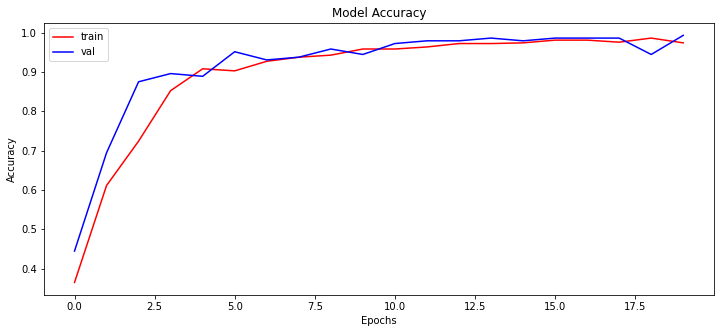

In [18]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

Evaluating the model to know the accuracy of the model.


In [19]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 0s 37ms/step - loss: 0.1186 - accuracy: 0.9889
Test Accuracy: 98.88888597488403


In [20]:
y_pred = model.predict(x_test)

6/6 [==============================] - 0s 17ms/step


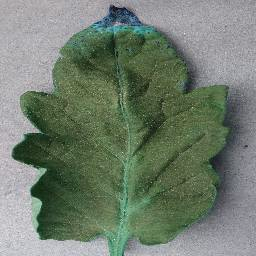

In [21]:
# Plotting image to compare
img = array_to_img(x_test[160])
img

Printing out the original and the predicted label.

In [22]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",all_labels[np.argmax(y_test[160])])
print("Predicted : ",all_labels[np.argmax(y_pred[160])])

Originally :  Tomato-Bacterial_spot
Predicted :  Tomato-Bacterial_spot
